### <메타데이터>
- Title : 뉴스기사 제목
- Text : 뉴스기사 본문
- Subject : 뉴스기사 제목
- Date : 뉴스기사 게재일
- Fake : 가짜뉴스 여부(1이면 가짜 , 0이면 진짜)

In [16]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
data = pd.read_csv('../data/sb_data.csv')

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35918 entries, 0 to 35917
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    35918 non-null  object
 1   text     35918 non-null  object
 2   subject  35918 non-null  object
 3   date     35918 non-null  object
 4   fake     35918 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.4+ MB


In [18]:
data.isnull().values.any() # 결측치 없음

False

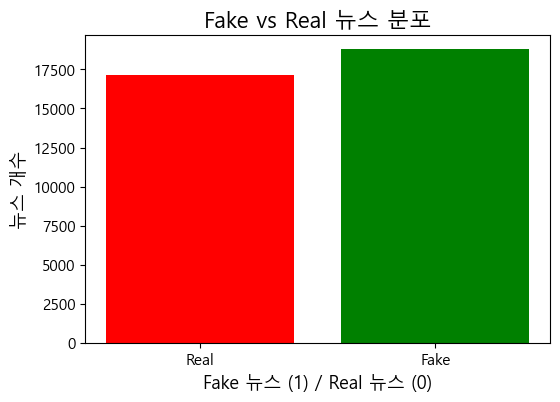

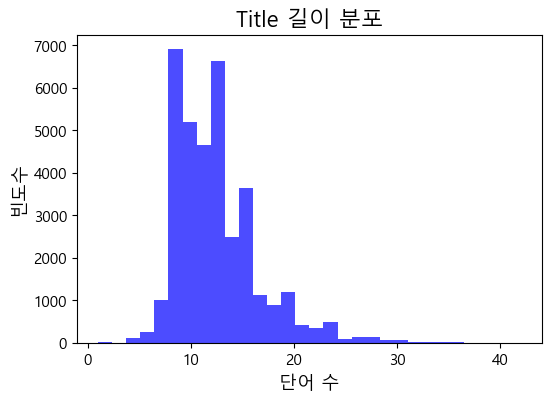

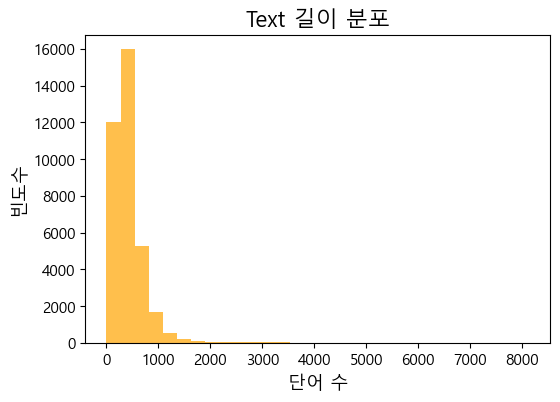

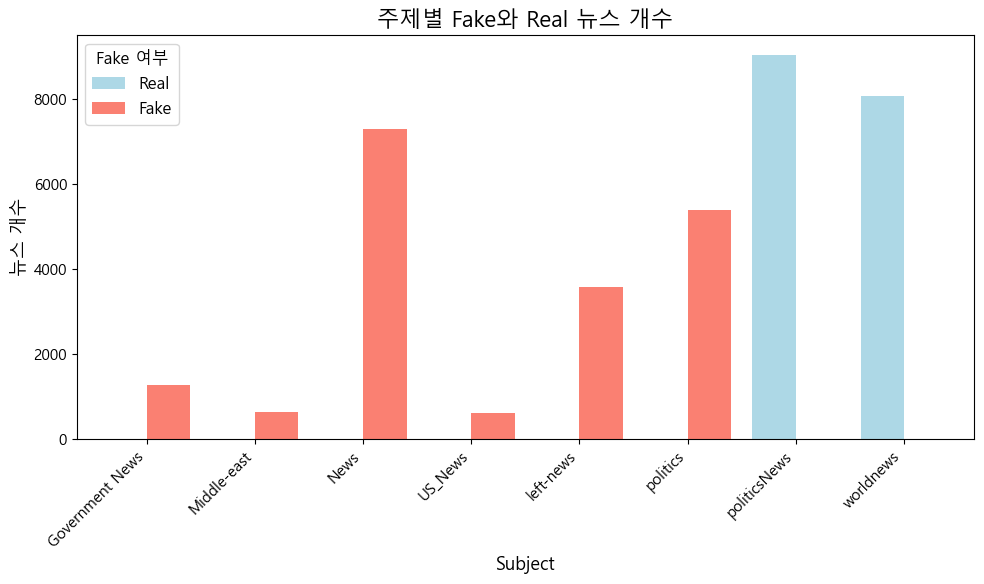

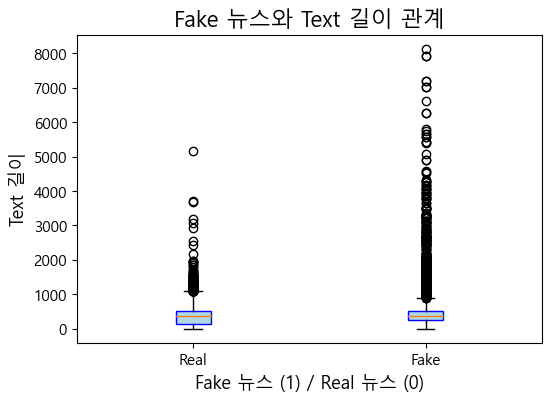

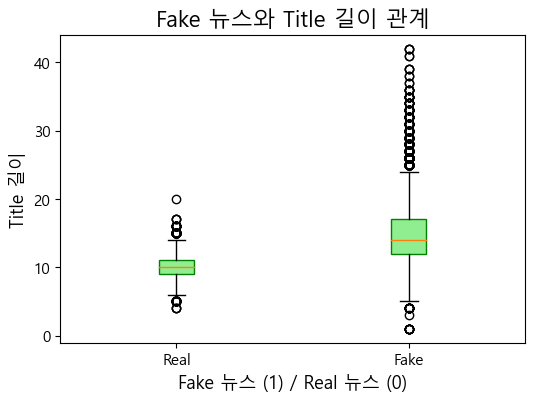

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
# 폰트 설정
plt.rc('font', family='Malgun Gothic', size=12)
plt.rc('axes', titlesize=16, labelsize=13)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)

# 데이터 로드
data = pd.read_csv('../data/sb_data.csv')

# 1. Fake vs Real 뉴스 분포
fake_counts = data['fake'].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(fake_counts.index, fake_counts.values, color=['green', 'red'])
plt.title('Fake vs Real 뉴스 분포')
plt.xlabel('Fake 뉴스 (1) / Real 뉴스 (0)')
plt.ylabel('뉴스 개수')
plt.xticks([0, 1], ['Real', 'Fake'])
plt.show()

# 2. Title 길이 분포
data['title_length'] = data['title'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(6, 4))
plt.hist(data['title_length'], bins=30, color='blue', alpha=0.7)
plt.title('Title 길이 분포')
plt.xlabel('단어 수')
plt.ylabel('빈도수')
plt.show()

# 3. Text 길이 분포
data['text_length'] = data['text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(6, 4))
plt.hist(data['text_length'], bins=30, color='orange', alpha=0.7)
plt.title('Text 길이 분포')
plt.xlabel('단어 수')
plt.ylabel('빈도수')
plt.show()

# 4. Subject와 Fake 뉴스의 관계
# 주제별로 fake(1)과 real(0)의 개수를 구합니다.
subject_fake_counts = data.groupby(['subject', 'fake']).size().unstack(fill_value=0)

# 주제별 fake(1)과 real(0)의 개수를 따로 그래프 표시
fig, ax = plt.subplots(figsize=(10, 6))

# 'real'과 'fake' 컬럼을 각각 다른 색상으로 막대그래프를 그립니다.
subject_fake_counts['real'] = subject_fake_counts[0]  # fake == 0인 부분은 'real'로 대체
subject_fake_counts['fake'] = subject_fake_counts[1]  # fake == 1인 부분은 'fake'로 대체

subject_fake_counts[['real', 'fake']].plot(kind='bar', stacked=False, width=0.8, color=['lightblue', 'salmon'], ax=ax)

# 그래프 제목 및 레이블 설정
plt.title('주제별 Fake와 Real 뉴스 개수')
plt.xlabel('Subject')
plt.ylabel('뉴스 개수')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Fake 여부', labels=['Real', 'Fake'])
plt.tight_layout()
plt.show()

# 5. Fake 뉴스와 text 길이 관계
plt.figure(figsize=(6, 4))
plt.boxplot([data[data['fake'] == 0]['text_length'], data[data['fake'] == 1]['text_length']], 
            labels=['Real', 'Fake'], patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'))
plt.title('Fake 뉴스와 Text 길이 관계')
plt.xlabel('Fake 뉴스 (1) / Real 뉴스 (0)')
plt.ylabel('Text 길이')
plt.show()

# 6. Fake 뉴스와 title 길이 관계
plt.figure(figsize=(6, 4))
plt.boxplot([data[data['fake'] == 0]['title_length'], data[data['fake'] == 1]['title_length']], 
            labels=['Real', 'Fake'], patch_artist=True, boxprops=dict(facecolor='lightgreen', color='green'))
plt.title('Fake 뉴스와 Title 길이 관계')
plt.xlabel('Fake 뉴스 (1) / Real 뉴스 (0)')
plt.ylabel('Title 길이')
plt.show()


In [20]:
# Subject와 Fake 뉴스의 관계
# 주제별로 fake(1)과 real(0)의 개수를 구합니다.
subject_fake_counts = data.groupby(['subject', 'fake']).size().unstack(fill_value=0)

# 결과를 출력
print("주제별 Fake와 Real 뉴스 개수:")
print(subject_fake_counts)

주제별 Fake와 Real 뉴스 개수:
fake                0     1
subject                    
Government News     0  1261
Middle-east         0   632
News                0  7301
US_News             0   620
left-news           0  3569
politics            0  5402
politicsNews     9056     0
worldnews        8077     0


In [21]:
# # 데이터 전처리
# data['title'] = data['title'].apply(lambda x : x.lower())
# data['text'] = data['text'].apply(lambda x : x.lower())

# data['content'] = data['title'] + ' ' + data['text']

# X = data['content']
# y = data['fake']

# data['content']


In [33]:
data['text'].nunique()

31764

In [34]:
data.drop_duplicates(subset=['text'], inplace=True)
print(f'총 샘플의 개수 : {len(data)}')

총 샘플의 개수 : 31764


In [36]:
data.groupby('fake').size().reset_index(name='count')

,fake,count
0,0,16984
1,1,14780


In [22]:
from string import punctuation
# 데이터 전처리
def repro(raw_sent):
    pro_sent = raw_sent.encode('utf8').decode('ascii', 'ignore')
    result = ''
    for w in pro_sent:
        if w not in punctuation: # 구두점 제거
            result += w
    return result.lower() # 소문자로 변환

In [23]:
re_text = []
# 전처리된 text 담기
for w in data['text']:
    pre_sent = repro(w)
    re_text.append(pre_sent)

re_text[:10]

['accra reuters  french president emmanuel macron fears islamist militants have scored military and symbolic victories in west africa while a regional military force has struggled to get off the ground a french presidential source said on thursday to help get the new g5 sahel force operating effectively he said france has invited the united states to a summit with the five participating countries as well as the african union and european union in paris next month  thousands of un peacekeepers french troops and us military trainers and drone operators have failed so far to stem a growing wave of jihadist violence leading world powers to pin their hopes on the new g5 sahel force the g5 sahel initiative  grouping burkina faso chad mali mauritania and niger  faces an immense security challenge in a largely desert and weakly governed region and already faces questions over its financing and provision of equipment  emmanuel macron believes that it s not going quickly enough and that the terr

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(re_text)

In [25]:
X_seq = tokenizer.texts_to_sequences(data['text'])

In [26]:
seq_lengths = [len(seq) for seq in X_seq]
max_len = max(seq_lengths)
max_len

8360

In [27]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_pad = pad_sequences(X_seq, maxlen = max_len, padding = 'pre')
print(X_pad[:3])

[[   0    0    0 ...    1  223   13]
 [   0    0    0 ...  145 2377   13]
 [   0    0    0 ...   33  159   75]]


In [28]:
X_pad = np.array(X_pad)

X = X_pad
y = y = data['fake']

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

In [ ]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential
embedding_dim = 8
hidden_units = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(SimpleRNN(hidden_units))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
360/360 [==============================] - 2723s 8s/step - loss: 0.3230 - acc: 0.8759 - val_loss: 0.1287 - val_acc: 0.9563
Epoch 2/5
360/360 [==============================] - 2913s 8s/step - loss: 0.0903 - acc: 0.9725 - val_loss: 0.0626 - val_acc: 0.9803
Epoch 3/5
329/360 [==========================>...] - ETA: 5:34 - loss: 0.0542 - acc: 0.9836

In [32]:
# LSTM 모델 구축
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM

vocab_size = len(tokenizer.word_index) + 1

model = Sequential()
model.add(Embedding(vocab_size, 128))
model.add(LSTM(64))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs = 200, batch_size=32)



Epoch 1/200
 43/898 [>.............................] - ETA: 2:39:16 - loss: 0.4982 - accuracy: 0.8198

KeyboardInterrupt: 

204669

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model accuracy: {accuracy*100:.2f}%')